# 题目：MLP实现图像多分类（手写数字识别）
## 实验目的与环境

目的

- 基于mnist数据集，建立MLP模型

- 使用模型实现0-9数字的十分类

- 手动实现神经网络正向传播和反向传播算法

- 熟悉交叉熵损失函数的计算方法

In [8]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))
class DenseLayer:
    def __init__(self, input_size, output_size,  activation=sigmoid, derivative=sigmoid_derivative):
        self.weights = np.random.randn(input_size, output_size)
        self.biases = np.zeros(output_size)
        self.output = None
        self.dinputs = None
        self.dweights = None
        self.dbiases = None
        self.activation = activation
        self.derivative = derivative


    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.activation(self.output)

    def backward(self, dvalues):
        dvalues = self.derivative(self.output) * dvalues
            
            
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs
    
    def update(self,learning_rate,samples):
        self.weights -= learning_rate * self.dweights / samples
        self.biases -= learning_rate * self.dbiases / samples


class LinearNetwork:
    def __init__(self):
        self.layers = []
        self.learning_rate = 0.01
        
    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        curr_input = inputs
        for layer in self.layers:
            curr_input =layer.forward(curr_input)
        return curr_input

    def backward(self, dvalues):
        n_samples, n_features = dvalues.shape
        curr_dvalues = dvalues
        for layer in reversed(self.layers):            
            curr_dvalues = layer.backward(curr_dvalues)

    def update(self,n_samples):
        for layer in self.layers:
            layer.update(self.learning_rate, n_samples)

    def train(self, inputs, targets):
        n_samples, n_features = inputs.shape
        output = self.forward(inputs)
        self.backward(output - targets)
        self.update(n_samples)
        loss = np.mean(np.square(output - targets))        
        return loss

    def fit(self, X, y, epochs=1000, batch_size=10,learning_rate=0.01):
        self.learning_rate = learning_rate
        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                batch_X = X[i:i+batch_size]
                batch_y = y[i:i+batch_size]
                loss = self.train(batch_X, batch_y)
            if epoch % 10 == 0:
                print(f"Epoch {epoch} loss: {loss}")
    
    def predict(self, X):
        return self.forward(X)

In [9]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)


class CrossEntropyLayer(DenseLayer):
    def __init__(self, input_size, output_size,):
        super(CrossEntropyLayer, self).__init__(input_size, output_size)
        self.activation = softmax
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.activation(self.output)
       
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

In [10]:
#load the dataset
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(type(X_train),X_train.shape)


<class 'numpy.ndarray'> (60000, 28, 28)


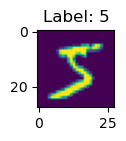

In [11]:
# visualize the data
import matplotlib.pyplot as plt
import numpy as np

img1 = X_train[0]
fig1 = plt.figure(figsize=(1, 1))
plt.imshow(img1)
plt.title('Label: %d' % y_train[0])
plt.show()

In [15]:
from tensorflow import keras

num_classes = 10
input_shape = (28, 28, 1)
feature_size = img1.shape[0] * img1.shape[1] 
print("feature_size", feature_size)

# format input data
X_train_normal = X_train.reshape(X_train.shape[0], feature_size).astype('float32') / 255.0
X_test_normal = X_test.reshape(X_test.shape[0], feature_size).astype('float32') / 255.0

# convert class vectors to binary class matrices
y_train_format = keras.utils.to_categorical(y_train, num_classes)
y_test_format = keras.utils.to_categorical(y_test, num_classes)

print("X_train_normal shape:", X_train_normal.shape)
print(X_train_normal[1])

feature_size 784
X_train_normal shape: (60000, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

In [13]:
model = LinearNetwork()

model.add_layer(DenseLayer(input_size=feature_size,output_size=30))
model.add_layer(DenseLayer(input_size=30,output_size=30))
model.add_layer(CrossEntropyLayer(input_size=30,output_size=10))
model.fit(X_train_normal,y_train_format,epochs=200,batch_size=32,learning_rate=0.001)

Epoch 0 loss: 0.09917023590682227
Epoch 10 loss: 0.09931192364583886
Epoch 20 loss: 0.09935161650765927


KeyboardInterrupt: 

In [23]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class SoftmaxRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # 数值稳定性调整
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        loss = np.mean(np.square(y_true - y_pred)) 
        #m = y_true.shape[0]
        #loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m  # 加入微小值以避免对数计算中的数值问题
        return loss

    def fit(self, X, y):
        m, n = X.shape
        i,k = y.shape
        self.weights = np.zeros((n, k))
        self.bias = np.zeros((1, k))

        for epoch in range(self.epochs):
            logits = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(logits)
            loss = self.compute_loss(y, y_pred)

            grad_w = np.dot(X.T, (y_pred - y)) / m
            grad_b = np.sum(y_pred - y, axis=0) / m

            self.weights -= self.learning_rate * grad_w
            self.bias -= self.learning_rate * grad_b

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.4f}')

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(logits)
        return np.argmax(y_pred, axis=1)

# 加载示例数据集
iris = load_iris()
X = iris.data
y = iris.target

# 将标签转换为独热编码
encoder = OneHotEncoder()
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# 初始化并训练模型
model = SoftmaxRegression(learning_rate=0.1, epochs=10000)
model.fit(X_train, y_train)

# 预测并评估模型
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
print(f'Accuracy: {accuracy:.4f}')

Epoch 0, Loss: 0.2222
Epoch 100, Loss: 0.0944
Epoch 200, Loss: 0.0425
Epoch 300, Loss: 0.0339
Epoch 400, Loss: 0.0288
Epoch 500, Loss: 0.0256
Epoch 600, Loss: 0.0234
Epoch 700, Loss: 0.0217
Epoch 800, Loss: 0.0205
Epoch 900, Loss: 0.0195
Epoch 1000, Loss: 0.0187
Epoch 1100, Loss: 0.0181
Epoch 1200, Loss: 0.0175
Epoch 1300, Loss: 0.0170
Epoch 1400, Loss: 0.0166
Epoch 1500, Loss: 0.0163
Epoch 1600, Loss: 0.0160
Epoch 1700, Loss: 0.0157
Epoch 1800, Loss: 0.0154
Epoch 1900, Loss: 0.0152
Epoch 2000, Loss: 0.0150
Epoch 2100, Loss: 0.0148
Epoch 2200, Loss: 0.0147
Epoch 2300, Loss: 0.0145
Epoch 2400, Loss: 0.0144
Epoch 2500, Loss: 0.0142
Epoch 2600, Loss: 0.0141
Epoch 2700, Loss: 0.0140
Epoch 2800, Loss: 0.0139
Epoch 2900, Loss: 0.0138
Epoch 3000, Loss: 0.0137
Epoch 3100, Loss: 0.0136
Epoch 3200, Loss: 0.0135
Epoch 3300, Loss: 0.0135
Epoch 3400, Loss: 0.0134
Epoch 3500, Loss: 0.0133
Epoch 3600, Loss: 0.0133
Epoch 3700, Loss: 0.0132
Epoch 3800, Loss: 0.0131
Epoch 3900, Loss: 0.0131
Epoch 4000, 

准确率: 0.1135


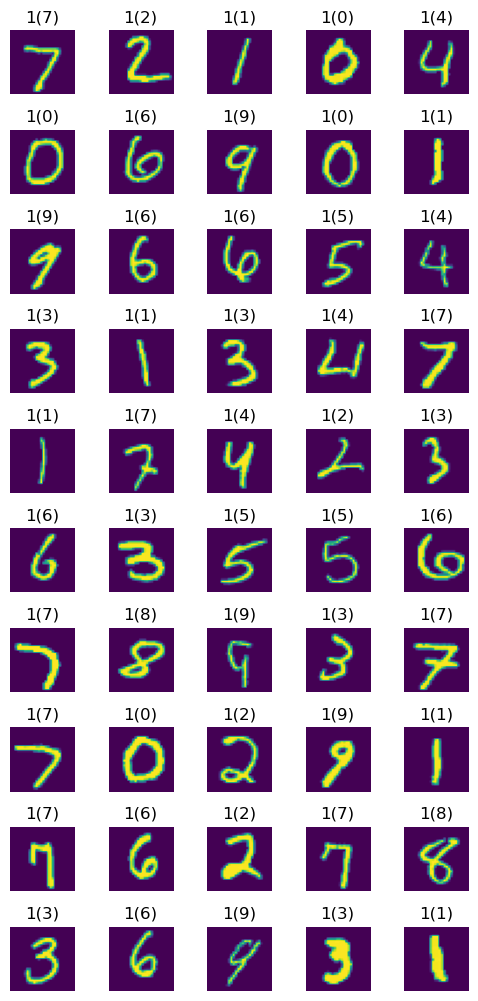

In [7]:
y_test_predict = model.predict(X_test_normal)
y_test_predict = np.argmax(y_test_predict, axis=1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_predict)
print("准确率:", accuracy)

# 绘制预测结果
fig1 = plt.figure(figsize=(10,40))
for i in range(10):
    for j in range(5):
        index = i*10+j
        img = X_test[index]
        value = str(y_test_predict[index]) + "(" + str(y_test[index]) + ")"
        plt.subplot(40,10,index+1)
        plt.title(value)
        plt.imshow(img)
        plt.axis('off')

plt.tight_layout()
plt.show()

准确率: 0.9416666666666667


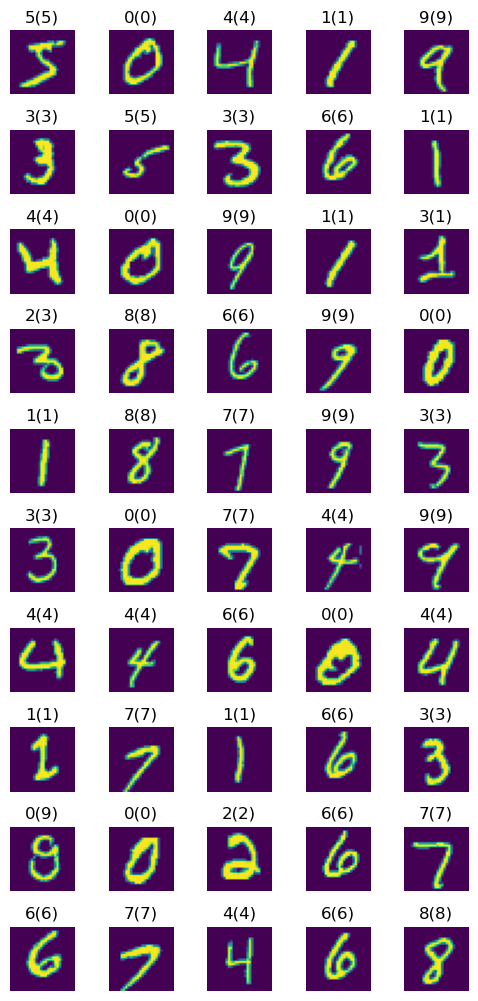

In [16]:
y_train_predict = model.predict(X_train_normal)
y_train_predict = np.argmax(y_train_predict, axis=1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, y_train_predict)
print("准确率:", accuracy)

# 绘制预测结果
fig1 = plt.figure(figsize=(10,40))
for i in range(10):
    for j in range(5):
        index = i*10+j
        img = X_train[index]
        value = str(y_train_predict[index]) + "(" + str(y_train[index]) + ")"
        plt.subplot(40,10,index+1)
        plt.title(value)
        plt.imshow(img)
        plt.axis('off')
plt.tight_layout()
plt.show()